In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

In [4]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
rest_affine = voxel_fmri.affine

In [5]:
### Compute the pcc seed connectivity
# Load the rest fmri in MNI space volumes

ftimecourse = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').get_fdata()
rest_affine = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').affine

# Visualize the corresponding probabilstic voxels for this region
root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'
atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'
prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [6]:
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))

100%|██████████| 95/95 [00:21<00:00,  4.36it/s]


In [7]:
p1,p2 = 0,0
bundle_opt = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_p1-{p1}_p2-{p2}.pkl")

### Hierarchical clustering on optimized bundles' values

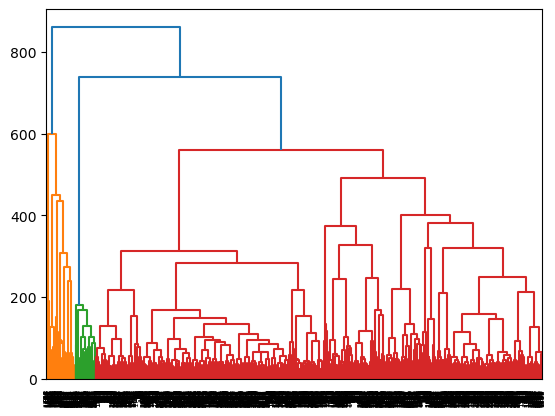

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_data = linkage(bundle_opt.T, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [60]:
from sklearn.cluster import AgglomerativeClustering

Nc = 6
cluster = AgglomerativeClustering(
    n_clusters=Nc, affinity='euclidean', linkage='ward')

cluster.fit(bundle_opt.T)

labels = cluster.labels_

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [63]:
cluster_opts = []
for k in range(Nc):
    cluster_opt = np.zeros_like(bundle_opt[0])
    cluster_opt[np.where(labels==k)[0]] = 1.0
    cluster_opts.append(cluster_opt)

In [64]:
cluster_inpainteds = []
for k in range(Nc):
    _, cluster_inpainted = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, cluster_opts[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)
    cluster_inpainteds.append(cluster_inpainted)

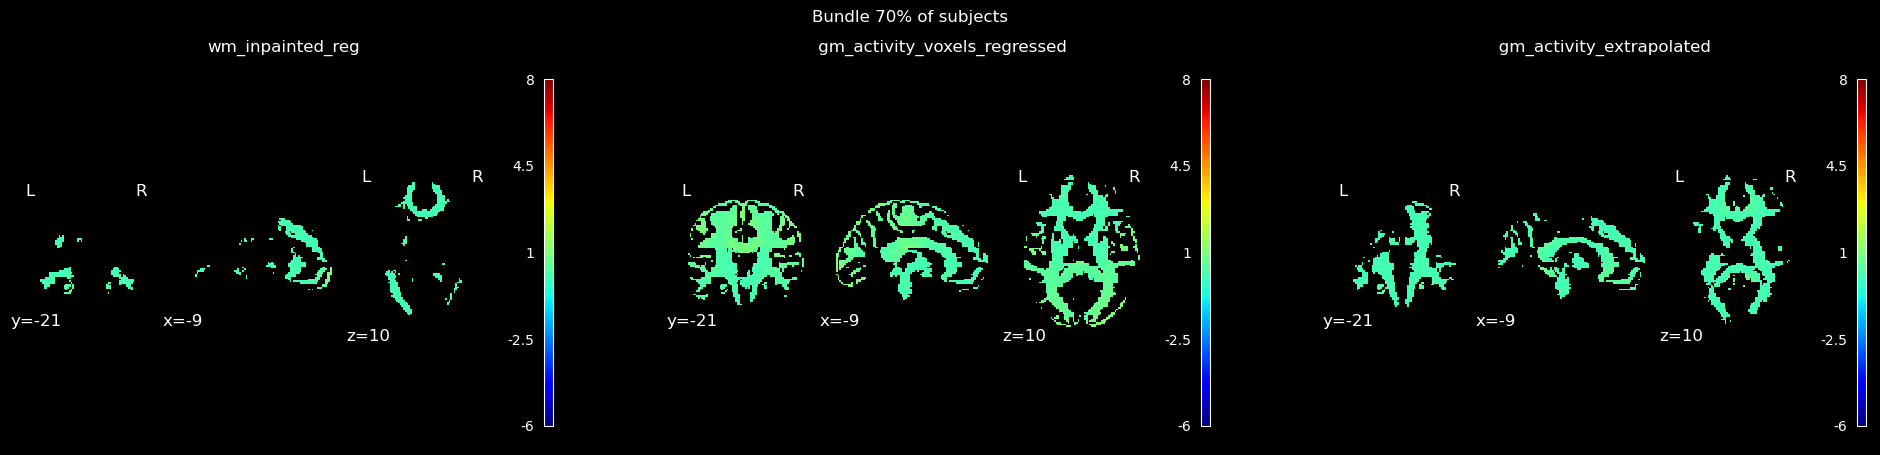

In [66]:
inpaint_mods = cluster_inpainteds[:3]
all_inpaints_names = f'wm_inpainted_reg, gm_activity_voxels_regressed,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-6, vmax=8)

### Hierarchical clustering on inpainting activity

In [67]:
# Inpainting
inpainted_timecourse = []
for k in tqdm(range(ftimecourse.shape[-1])):
    _, wm_masked = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)
    inpainted_timecourse.append(wm_masked)
inpainted_timecourse = np.array(inpainted_timecourse)

100%|██████████| 460/460 [07:10<00:00,  1.07it/s]


In [80]:
wm_masked_activities = []
for k in range(len(inpainted_timecourse)):
    frame_wm_activity = inpainted_timecourse[k][wm_mask_subj.astype(bool)]
    frame_wm_activity[frame_wm_activity == -100000] = 0.
    wm_masked_activities.append(frame_wm_activity)
wm_masked_activities = np.array(wm_masked_activities)

In [84]:
Nc = 4
cluster = AgglomerativeClustering(n_clusters=Nc, affinity='euclidean', linkage='ward')

cluster.fit(wm_masked_activities.T)

labels = cluster.labels_

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
wm_clusters = []
for k in range(Nc):
    wm_cluster = np.zeros_like(inpainted_timecourse[0])
    wm_cluster[wm_mask_subj] = (labels == k).astype(float)
    wm_cluster[wm_cluster == 0] = -1000
    wm_clusters.append(wm_cluster)

In [ ]:
inpaint_mods = wm_clusters[:3]
all_inpaints_names = f'wm_inpainted_reg, gm_activity_voxels_regressed,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-6, vmax=8)